
# Data and computations for paper 

Lars G. Johnsen
National Library of Norway

In [138]:
import dhlab.nbtext as nb
import dhlab.module_update as mu
mu.update('collocations')
from collocations import dist_coll_urn
import pandas as pd

Updated file `D:\Documents\GitHub\newspapers_coll_conc\collocations.py`

In [139]:
def df_jaccard(df, col1, col2, number=100, asc=False):
    s1 = df.sort_values(by=col1, ascending=asc)[:number].index
    s2 = df.sort_values(by=col2, ascending=asc)[:number].index
    
    #print(len(set(s1)&set(s2)))
    
    return jaccard(s1, s2)

In [140]:
def jaccard(s1, s2):
    return len(set(s1)&set(s2))/len(set(s1)|set(s2))

In [172]:
def make_coll_df(small, large, tot):
    """take two collocations, small and large, and a reference tot. The reference must av a column call tot as well"""
    coll = pd.DataFrame()
    coll['small'] = small['freq']
    coll['large'] = large['freq']
    #coll['ratio'] = coll['small']/coll['large']
    coll['srel'] = coll.small/coll.small.sum()
    coll['lrel'] = coll.large/coll.large.sum()
    coll['ratio'] = coll.srel/coll.lrel
    coll['adjusted'] = coll.small**0.01*coll.ratio
    coll['nb'] = coll.small/tot.tot
    return coll

### Reference corpus

The reference is the total counts from approximately 450 000 books from nb.no

In [142]:
tot = nb.frame(nb.totals(50000), 'tot')

In [143]:
nb.normalize_corpus_dataframe(tot)
tot.head()

,tot
.,0.058921
",",0.051453
og,0.025297
i,0.021425
det,0.012728


# Corpus

The corpus for doing collocations is a sample of 800 books from fictional literature, dewey decimal code 813.

In [144]:
corpus = nb.book_corpus(ddk="813%", period=(1980, 2000), limit = 5000)

In [145]:
corpus

,urn,author,title,year
0,2007112601038,"Conroy, Pat",Tidevannets fyrste,1992
1,2009070200063,"Garlock, Dorothy",Hjertets stemme,1993
2,2008030300123,"Morrell, David",Tilbake til livet,1995
3,2008090100099,"William, Kate",Bitre rivaler,1999
4,2016061508057,"Stout, Rex",Sin fars hus,1980
...,...,...,...,...
4995,2009072100092,"Dixon, Franklin W.",Hardyguttene løser kodemysteriet,1991
4996,2015030606048,"Dickson, Carter",Bøddelen går igjen,1985
4997,2009011500040,"Stine, R.L.",Hvordan jeg lærte å fly,2000
4998,2008011601039,"Chandler, Raymond",Lillesøster,1994


Set up the distance parameters and collword, smd is small distance while lmd is large distance. These values are half of the actual window, and used to make a normalized score, call ascore. See below.

In [146]:
smd = 5
lmd = 10
collword = 'spise'

In [147]:
def large_corpus_coll(collword, urns = None, after= 5, before = 5, n = 300):
    colls = []
    for i in range(0, len(urns), n):
        colls.append(nb.urn_coll(collword, urns=urns[i:i + n], after= after, before = before))
    coll = pd.concat(colls, axis=1, sort=False).sum(axis=1)
    return pd.DataFrame(coll)

In [148]:
a1 = nb.frame(large_corpus_coll(collword, urns=list(corpus.urn), after= int(2*smd), before = 0), 'freq')
a2 = nb.frame(large_corpus_coll(collword, urns=list(corpus.urn), after= int(2*lmd), before = 0), 'freq')

In [149]:
b1 = nb.frame(large_corpus_coll(collword, urns=list(corpus.urn), after=0, before = int(2*smd)), 'freq')
b2 = nb.frame(large_corpus_coll(collword, urns=list(corpus.urn), after=0, before = int(2*lmd)), 'freq')

## Create collocation dataframe 

Based on data from a1 and a2, and b1 and b2. The name for the collocations after is `coll` while `collb` is for the collocates coming before.

In [173]:
coll = make_coll_df(a1, a2, tot)
collb = make_coll_df(b1, b2, tot)

## Sorting 

Sorting on the reference is by column 'nb'

In [174]:
coll[coll.small > 1].sort_values(by='nb', ascending=False)[:20][:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
lunsj,4192,4372,0.00755424,0.00403805,1.87077,2.0335,3.75262e+08
middag,7032,7301,0.0126721,0.00674332,1.87921,2.05327,2.33117e+08
frokost,2058,2186,0.00370864,0.00201902,1.83685,1.98248,1.58442e+08
aftens,354,369,0.00063793,0.000340814,1.87178,1.98493,1.5341e+08
pizza,242,283,0.000436099,0.000261383,1.66843,1.76257,1.07738e+08
kveldsmat,154,163,0.000277517,0.000150549,1.84336,1.93859,1.00199e+08
lunch,122,129,0.000219852,0.000119146,1.84522,1.93603,8.68896e+07
iskrem,104,121,0.000187414,0.000111758,1.67697,1.7567,5.81205e+07
kvelds,96,101,0.000172998,9.32852e-05,1.85451,1.94111,5.19718e+07
sulten,209,425,0.000376631,0.000392537,0.959479,1.01213,4.75057e+07


In [152]:
coll[coll.small < coll.large].sort_values(by='ratio', ascending=False)[:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,nb
middag,7032,7301,0.0126721,0.00674332,1.87921,2.33117e+08
frokost.,25,26,4.50515e-05,2.4014e-05,1.87605,0
aftens,354,369,0.00063793,0.000340814,1.87178,1.5341e+08
lunsj,4192,4372,0.00755424,0.00403805,1.87077,3.75262e+08
"frokost,",20,21,3.60412e-05,1.93959e-05,1.85818,0
kvelds,96,101,0.000172998,9.32852e-05,1.85451,5.19718e+07
brødskiver,19,20,3.42392e-05,1.84723e-05,1.85354,1.63189e+07
lunch,122,129,0.000219852,0.000119146,1.84522,8.68896e+07
kveldsmat,154,163,0.000277517,0.000150549,1.84336,1.00199e+08
frokost,2058,2186,0.00370864,0.00201902,1.83685,1.58442e+08


# collb

In [153]:
collb[collb.small < collb.large].sort_values(by='ratio', ascending=False)[:40].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,nb
invitasjon,31,33,5.58639e-05,3.05563e-05,1.82823,1.12916e+07
fryd,15,16,2.70309e-05,1.48152e-05,1.82454,1.89818e+06
Klar,13,14,2.34268e-05,1.29633e-05,1.80716,4.66361e+06
Candy,12,13,2.16247e-05,1.20373e-05,1.79647,8.92899e+06
Lyst,47,51,8.46969e-05,4.72234e-05,1.79353,5.05474e+06
skaff,11,12,1.98227e-05,1.11114e-05,1.78399,5.43352e+06
ferdige,556,611,0.00100195,0.000565755,1.77099,2.54077e+07
velkledde,10,11,1.80206e-05,1.01854e-05,1.76925,0
avskyr,10,11,1.80206e-05,1.01854e-05,1.76925,6.53872e+06
ropt,10,11,1.80206e-05,1.01854e-05,1.76925,2.1266e+06


In [154]:
collb.sort_values(by='nb', ascending=False)[:40].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,nb
sulten,308,557,0.000555035,0.000515754,1.07616,7.00084e+07
dusje,43,51,7.74886e-05,4.72234e-05,1.64089,3.76549e+07
gaffelen,74,112,0.000133353,0.000103706,1.28587,3.59339e+07
skjeen,50,77,9.01031e-05,7.12981e-05,1.26375,2.84895e+07
tallerkenen,123,254,0.000221654,0.000235191,0.94244,2.64003e+07
ferdige,556,611,0.00100195,0.000565755,1.77099,2.54077e+07
suiten,209,375,0.000376631,0.000347231,1.08467,2.19021e+07
spisesalen,56,82,0.000100915,7.59279e-05,1.3291,2.12367e+07
matlyst,21,36,3.78433e-05,3.33342e-05,1.13527,2.01014e+07
insisterte,116,149,0.000209039,0.000137967,1.51514,2.00511e+07


# coll

In [163]:
coll[coll.small < coll.large].sort_values(by='ratio', ascending=False)[:10].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,nb
middag,7032,7301,0.0126721,0.00674332,1.87921,2.33117e+08
frokost.,25,26,4.50515e-05,2.4014e-05,1.87605,0
aftens,354,369,0.00063793,0.000340814,1.87178,1.5341e+08
lunsj,4192,4372,0.00755424,0.00403805,1.87077,3.75262e+08
"frokost,",20,21,3.60412e-05,1.93959e-05,1.85818,0
kvelds,96,101,0.000172998,9.32852e-05,1.85451,5.19718e+07
brødskiver,19,20,3.42392e-05,1.84723e-05,1.85354,1.63189e+07
lunch,122,129,0.000219852,0.000119146,1.84522,8.68896e+07
kveldsmat,154,163,0.000277517,0.000150549,1.84336,1.00199e+08
frokost,2058,2186,0.00370864,0.00201902,1.83685,1.58442e+08


In [157]:
coll.sort_values(by='nb', ascending=False)[:10].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,nb
lunsj,4192,4372,0.00755424,0.00403805,1.87077,3.75262e+08
middag,7032,7301,0.0126721,0.00674332,1.87921,2.33117e+08
frokost,2058,2186,0.00370864,0.00201902,1.83685,1.58442e+08
aftens,354,369,0.00063793,0.000340814,1.87178,1.5341e+08
pizza,242,283,0.000436099,0.000261383,1.66843,1.07738e+08
kveldsmat,154,163,0.000277517,0.000150549,1.84336,1.00199e+08
lunch,122,129,0.000219852,0.000119146,1.84522,8.68896e+07
iskrem,104,121,0.000187414,0.000111758,1.67697,5.81205e+07
kvelds,96,101,0.000172998,9.32852e-05,1.85451,5.19718e+07
sulten,209,425,0.000376631,0.000392537,0.959479,4.75057e+07


# jaccard similarity

# for collb

In [170]:
jaccard_scoresb = nb.frame({'ratio': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'ratio', x) for x in range(5, 210, 5)},
                            'srel': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'srel', x) for x in range(5, 210, 5)},
                           'lrel': {x:df_jaccard(collb[collb.small < collb.large], 'nb', 'lrel', x) for x in range(5, 210, 5)}
                          }).transpose()

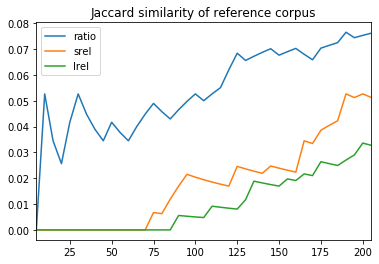

In [171]:
jaccard_scoresb.plot(title='Jaccard similarity of reference corpus');

# for coll

In [168]:
jaccard_scores = nb.frame({'ratio': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'ratio', x) for x in range(5, 210, 5)},
                            'srel': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'srel', x) for x in range(5, 210, 5)},
                           'lrel': {x:df_jaccard(coll[coll.small < coll.large], 'nb', 'lrel', x) for x in range(5, 210, 5)}
                          }).transpose()

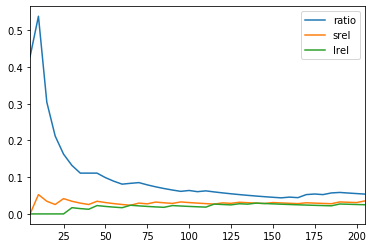

In [169]:
jaccard_scores.plot();

In [165]:
df_jaccard(coll[coll.small < coll.large], 'nb', 'ratio', 5)

0.42857142857142855